# Colorisation d'image (Noir et blanc)

Le but de ce TP est de mettre en place une colorisation automatique de photos en noir et blanc

## Introduction : Formats d'image

De nombreux très nombreux formats de stockage d'image en couleur sont possible sur 3 ou 4 canals je vous laisse regarder ici (doc de CV2) qulques formules de conversion.

https://docs.opencv.org/4.2.0/de/d25/imgproc_color_conversions.html


In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

Récupération d'une image pour tester (appel d'une commande unix en local)

In [ ]:
!wget 'https://www.dreamyachtcharter.com/wp-content/uploads/2019/03/dyc_ourdays_cuba_web-8-377x207.jpg'

cv2 (open-cv) est une bibliothèque très puissante mais attention les images sont en format GRB par défaut !

(207, 377, 3)
(207, 377)


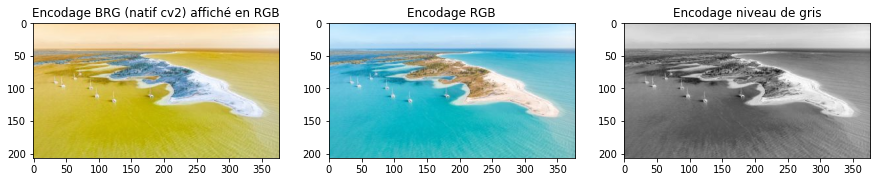

In [4]:
image = cv2.imread('dyc_ourdays_cuba_web-8-377x207.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
print(image_gray.shape)
fig=plt.figure(figsize=(15, 8))
fig.add_subplot(1,3, 1)
plt.title('Encodage BRG (natif cv2) affiché en RGB')
plt.imshow(image)
fig.add_subplot(1,3, 2)
plt.title('Encodage RGB')
plt.imshow(image_rgb)
fig.add_subplot(1,3, 3)
plt.title('Encodage niveau de gris')
plt.imshow(image_gray,cmap='gray')

## Format Lab (Light, Green-to-Red, Blue-to-Yellow) (0:255,0:255,0:255)

la couche L (Ligthness) donne la luminosité de l'image, a et b sont des composantes de chrominance (la couleur).
a de vert à rouge et b de bleu à jaune.

Voici un exemple de séparation des couleurs. Pour pouvoir afficher avec les bonnes couleur les caneaux sont isolés et reconvertis en RGB pour les voir dans les bonnes teintes.

(207, 377, 3)


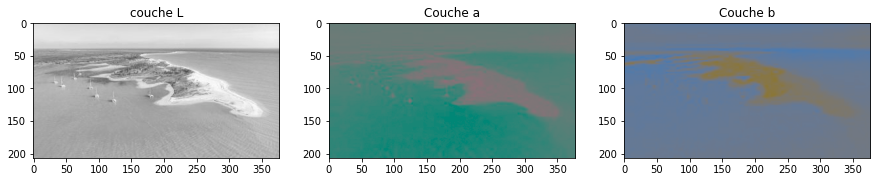

In [5]:
image_Lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
print(image_Lab.shape)
fig=plt.figure(figsize=(15, 8))
## Affichage L (on repasse en RGB noté les valeur des couches a et b à 128)
fig.add_subplot(1,3, 1)
plt.title('couche L')
image_L = image_Lab.copy()
image_L[:,:,1:]=128
image_L = cv2.cvtColor(image_L, cv2.COLOR_LAB2RGB)
plt.imshow(image_L)
## Affichage a (on repasse en RGB noté les valeurs L et b à 128)
fig.add_subplot(1,3, 2)
plt.title('Couche a')
image_a = image_Lab.copy()
image_a[:,:,0]=128
image_a[:,:,2]=128
image_a = cv2.cvtColor(image_a, cv2.COLOR_LAB2RGB)
plt.imshow(image_a)
## Affichage a (on repasse en RGB noté les valeurs L et a à 128)
fig.add_subplot(1,3, 3)
plt.title('Couche b')
image_b = image_Lab.copy()
image_b[:,:,0]=128
image_b[:,:,1]=128
image_b = cv2.cvtColor(image_b, cv2.COLOR_LAB2RGB)
plt.imshow(image_b)

## Dataset CIFAR100 (images couleurs 32x32x3)

L' ensemble de données CIFAR-100 (Institut canadien de recherche avancée, 100 classes) est un sous-ensemble de l'ensemble de données "Tiny Images" et se compose de 60000 images couleur 32x32. Les 100 classes du CIFAR-100 sont regroupées en 20 superclasses. Il y a 600 images par classe. Chaque image est livrée avec une étiquette "fine" (la classe à laquelle elle appartient) et une étiquette "grossière" (la superclasse à laquelle elle appartient). Il y a 500 images de formation et 100 images de test par classe.

Nous nous serviront de cet ensemble suffisemment riche pour colorier nos images.

Nous alons procéder en 2 temps chaque image de taille 32x32x3 est encodée au Format Lab ensuite nous gardons le canal L comme entrée du réseau et prédirons les canaux ab.

Les données sont normalisée normalisées, (il faudra post-traiter pour visualiser).
* L entre 0 et 1
* a entre -1 et 1 (utiliser tanh comme fonction d'activation)
* b entre -1 et 1 (utiliser tanh comme fonction d'activation)


In [6]:
from keras.datasets import cifar100
# on ne récupère pas les labels
(x_train, _), (x_test, _) = cifar100.load_data()

169009152/169001437 [==============================] - 4s 0us/step


In [7]:
x_train.shape

(50000, 32, 32, 3)

In [8]:
x_test.shape

(10000, 32, 32, 3)

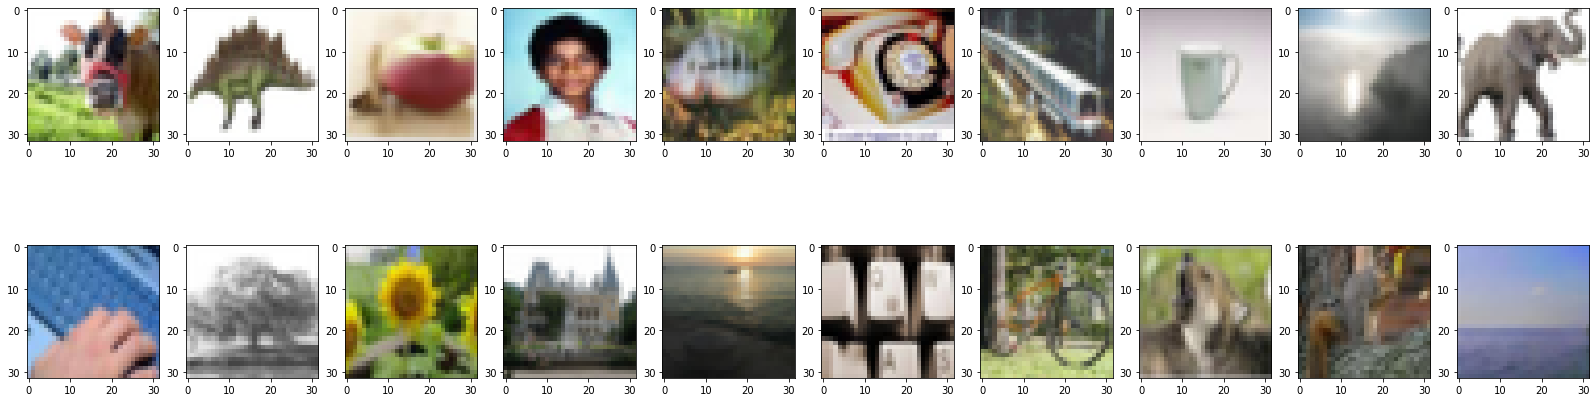

In [9]:
fig=plt.figure(figsize=(28, 8))
n=20
start=0
for i in range(0, n):
    fig.add_subplot(2,10,i+1)
    plt.imshow(x_train[i+start])
plt.show()

## Mise en place du jeux de donnée

X et Y comme ensemble d'entrainement et Xt et Yt comme ensemble test
Nous stockons donc le canal L des images das X (et Xt) et les canneaux a et b dans Y (et Yt)

### Calcul X et Y (set apprentissage)

In [10]:
X=[]
Y=[]
for i in range(0,x_train.shape[0]):
    im=x_train[i]
    im=cv2.cvtColor(im, cv2.COLOR_RGB2LAB)
    X.append(np.float32(im[:,:,0:1])/255)
    Y.append(np.float32(im[:,:,1:])/128-1)
X=np.array(X)
Y=np.array(Y)

In [11]:
X.shape

(50000, 32, 32, 1)

### Calcul Xt et Yt (set de test)

In [12]:
Xt=[]
Yt=[]
for i in range(0,x_test.shape[0]):
    im=x_test[i]
    im=cv2.cvtColor(im, cv2.COLOR_RGB2LAB)
    Xt.append(np.float32(im[:,:,0:1])/255)
    Yt.append(np.float32(im[:,:,1:])/128-1)
Xt=np.array(Xt)
Yt=np.array(Yt)

In [13]:
Xt.shape

(10000, 32, 32, 1)

## Principe : Encoder - Décoder 

Partie encoder : extraie les caractéristiques des images encoder identique pour de la classification d'image

Partie decoder : reconstruit les couches de couleur à partir des caractéristiques

![](https://xiangyutang2.github.io/auto-colorization-autoencoders/autoencoder.png)

Exemple simple :

In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import datasets, layers, models, losses, Sequential, Model

In [15]:
#Design the neural network
model = Sequential()
# encoder
model.add(layers.InputLayer(input_shape=(32, 32 ,1)))
model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
# decoder
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(layers.UpSampling2D((2, 2)))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 8)         584       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 16)          2320      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 32)          9248      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 64)          1

In [17]:
model.compile(optimizer='rmsprop',loss='mse',metrics=["accuracy"])

In [18]:
history = model.fit(x=X, y=Y, validation_data=(Xt, Yt), batch_size=100, epochs=200, verbose=1)

Epoch 1/200
500/500 [==============================] - 83s 162ms/step - loss: 0.0159 - accuracy: 0.5895 - val_loss: 0.0154 - val_accuracy: 0.5987
Epoch 2/200
500/500 [==============================] - 79s 158ms/step - loss: 0.0150 - accuracy: 0.6009 - val_loss: 0.0147 - val_accuracy: 0.6075
Epoch 3/200
500/500 [==============================] - 79s 158ms/step - loss: 0.0146 - accuracy: 0.6081 - val_loss: 0.0144 - val_accuracy: 0.6168
Epoch 4/200
500/500 [==============================] - 80s 160ms/step - loss: 0.0144 - accuracy: 0.6153 - val_loss: 0.0143 - val_accuracy: 0.6117
Epoch 5/200
500/500 [==============================] - 77s 154ms/step - loss: 0.0143 - accuracy: 0.6168 - val_loss: 0.0143 - val_accuracy: 0.6170
Epoch 6/200
500/500 [==============================] - 77s 155ms/step - loss: 0.0141 - accuracy: 0.6218 - val_loss: 0.0142 - val_accuracy: 0.6081
Epoch 7/200
500/500 [==============================] - 77s 154ms/step - loss: 0.0138 - accuracy: 0.6226 - val_loss: 0.0142 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


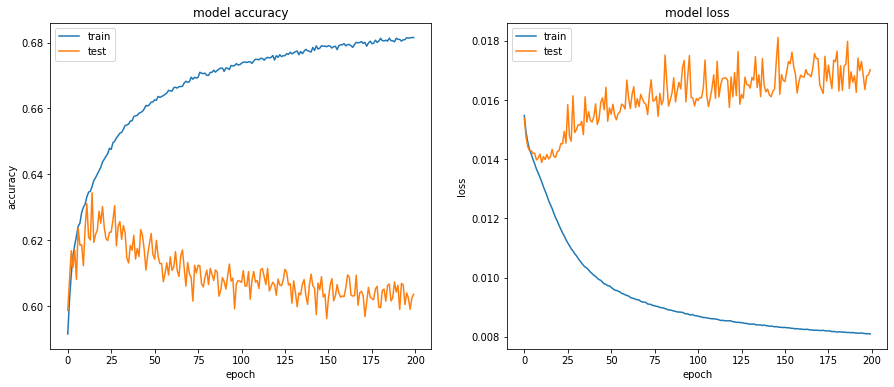

In [19]:
print(history.history.keys())
fig=plt.figure(figsize=(15, 6))
# summarize history for accuracy
fig.add_subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
fig.add_subplot(1,2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Analyse

Clairement on voit ici une courbe avec un effet de surapprentissage. Sur l'échantillon Test on retiendra une "accuracy" de 60-62%.

Regardons visuellement la couleur de nos images

## Reconstruction et visualisation de la colorisation

In [20]:
# calcul de la prédiction (long)
Y_p  = model.predict(X)
Yt_p = model.predict(Xt)

In [21]:
# conversion de la prédiction
# enseble d'apprentissage
Imag_p=[]
for i in range(0,len(X)):
    im=np.zeros((32,32,3),np.uint8)
    im[:,:,0:1]=np.uint8(X[i]*255)
    im[:,:,1:]=np.uint8((Y_p[i][:,:,0:]+1)*128)
    image=cv2.cvtColor(im, cv2.COLOR_LAB2RGB)
    Imag_p.append(image)
# Ensemble test
Imagt_p=[]
for i in range(0,len(Xt)):
    im=np.zeros((32,32,3),np.uint8)
    im[:,:,0:1]=np.uint8(Xt[i]*255)
    im[:,:,1:]=np.uint8((Yt_p[i][:,:,0:]+1)*128)
    image=cv2.cvtColor(im, cv2.COLOR_LAB2RGB)
    Imagt_p.append(image)

## Visualisation Ensemble apprentissage

A gauche l'original à droite l'image recolorée.

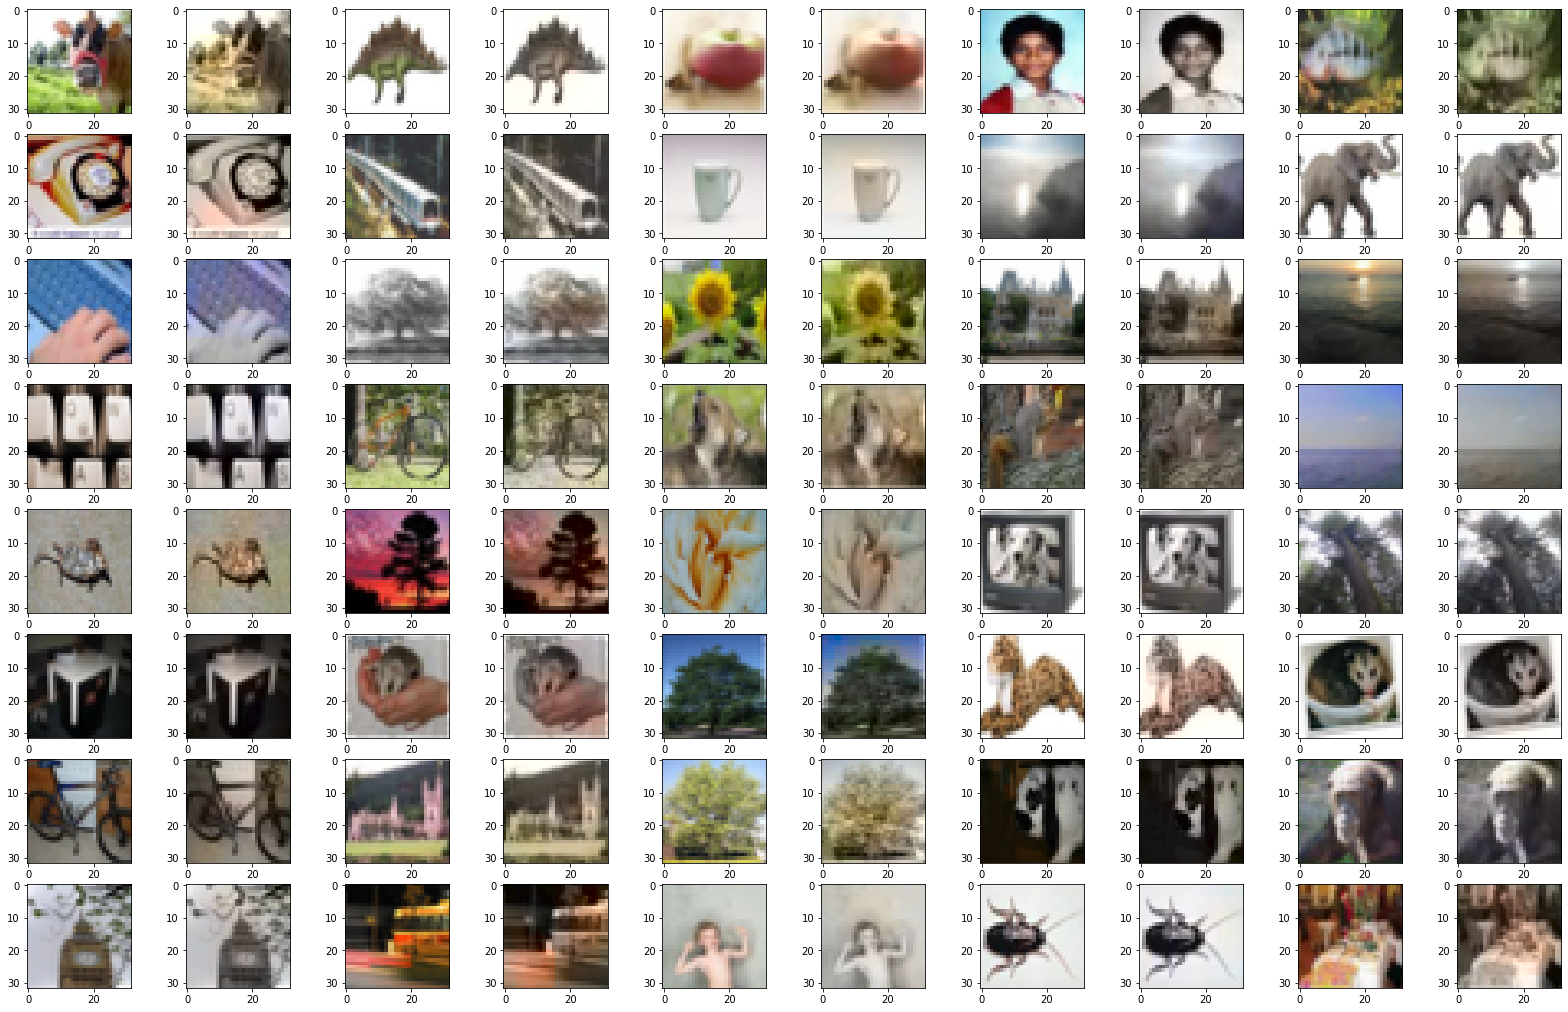

In [22]:
fig=plt.figure(figsize=(28, 18))
n=40 # multiple de 5 pour 8 lignes
start=0
for i in range(0, n):
    fig.add_subplot(8,10, 2*i+1)
    plt.imshow(x_train[i+start])
    fig.add_subplot(8,10, 2*i+2)
    plt.imshow(Imag_p[i+start])
plt.show()

## Sur ensemble test

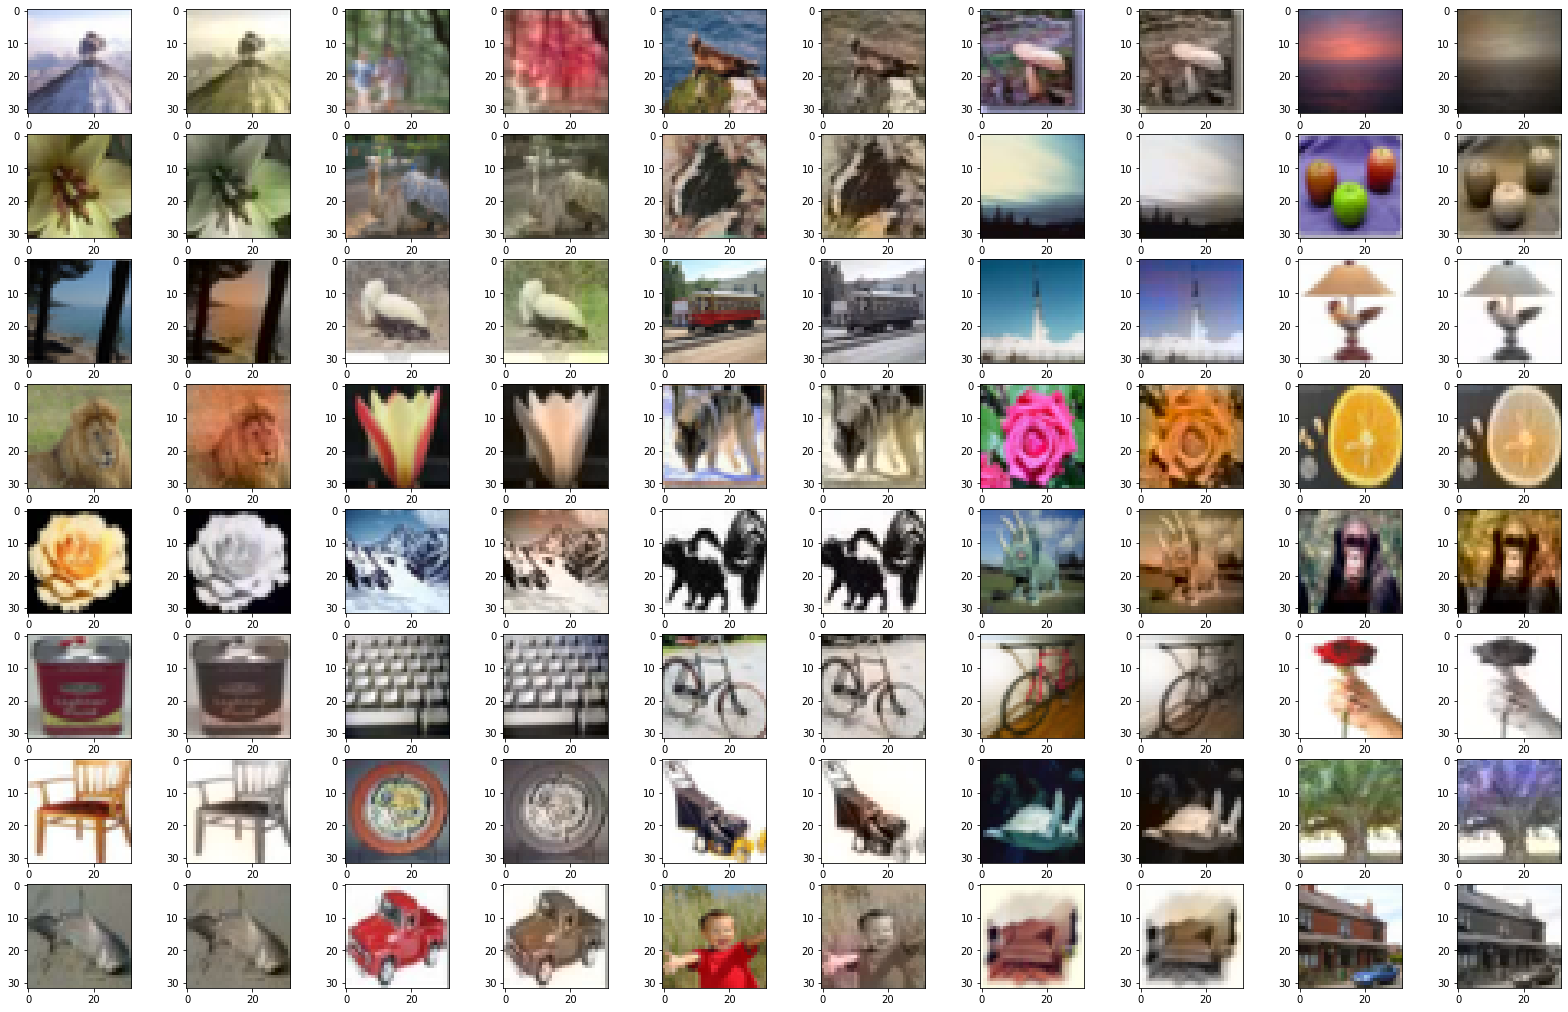

In [23]:
fig=plt.figure(figsize=(28, 18))
n=40
start=0
for i in range(0, n):
    fig.add_subplot(8,10, 2*i+1)
    plt.imshow(x_test[i+start])
    fig.add_subplot(8, 10, 2*i+2)
    plt.imshow(Imagt_p[i+start])
plt.show()

## Conclusion

On peut dire que sur l'échantillon d'pprentissage les couleurs sont approchantes, avec des exceptions (main bleue sur clavier). Pour ce qui est de l'échantillon test cela semble moins bien avec un arbre violet au lieu de vert mais néanmoins la rondelle de citron est presque jaune !

# Utilisation d'un encoder pré-déterminer

Essayons d'utiliser un encoder entrainer à l'aide de ImageNet

Popur une liste complète d'encoder avec leur "accuracy" sur ImageNet et autre :

https://keras.io/api/applications/

Il est possible de choisir un réseau moins gourmand...

**Attention l'entrée ne peut être que 32x32x3 !**

In [35]:
#base_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape = (32,32,3))
base_model = tf.keras.applications.ResNet50(include_top = False, input_shape = (32,32,3))
#base_model = tf.keras.applications.MobileNetV2(include_top = False, input_shape = (32,32,3))
#for layer in base_model.layers:
#  layer.trainable = False
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(base_model.output)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(2, (3, 3), activation='tanh', padding='same')(x)
model=Model(inputs = base_model.input, outputs = x)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [36]:
model.compile(optimizer='rmsprop',loss='mse',metrics=["accuracy"])

## Modification des éléments d'entrée

Cet Encoder prend en entrée des images couleur. Ici nous le tromperons avec une entrée avec 3 caneaux identiques pour former du gris.

Construction des images à trois caneaux identiques.

In [37]:
Xnew=[]
for i in range(0,len(X)):
    tmp=np.zeros((32,32,3))
    tmp[:,:,0]=X[i][:,:,0]
    tmp[:,:,1]=X[i][:,:,0]
    tmp[:,:,2]=X[i][:,:,0]
    Xnew.append(tmp)
Xnew= np.array(Xnew)

Xtnew=[]
for i in range(0,len(Xt)):
    tmp=np.zeros((32,32,3))
    tmp[:,:,0]=Xt[i][:,:,0]
    tmp[:,:,1]=Xt[i][:,:,0]
    tmp[:,:,2]=Xt[i][:,:,0]
    Xtnew.append(tmp)
Xtnew= np.array(Xtnew)

### Calcul avec ResNet50

In [38]:
#Train the neural network
history = model.fit(x=Xnew, y=Y, validation_data=(Xtnew, Yt), batch_size=100, epochs=100, verbose=1)

Epoch 1/100
500/500 [==============================] - 2694s 5s/step - loss: 0.0165 - accuracy: 0.5929 - val_loss: 0.0214 - val_accuracy: 0.4930
Epoch 2/100
500/500 [==============================] - 2657s 5s/step - loss: 0.0147 - accuracy: 0.6074 - val_loss: 0.0153 - val_accuracy: 0.5985
Epoch 3/100
500/500 [==============================] - 2638s 5s/step - loss: 0.0136 - accuracy: 0.6196 - val_loss: 0.0142 - val_accuracy: 0.6135
Epoch 8/100
500/500 [==============================] - 2640s 5s/step - loss: 0.0134 - accuracy: 0.6207 - val_loss: 0.0146 - val_accuracy: 0.6057
Epoch 9/100
500/500 [==============================] - 2650s 5s/step - loss: 0.0132 - accuracy: 0.6246 - val_loss: 0.0199 - val_accuracy: 0.5997
Epoch 10/100
500/500 [==============================] - 2632s 5s/step - loss: 0.0120 - accuracy: 0.6458 - val_loss: 0.0149 - val_accuracy: 0.6166
Epoch 15/100
500/500 [==============================] - 2640s 5s/step - loss: 0.0101 - accuracy: 0.6646 - val_loss: 0.0151 - val_

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 2628s 5s/step - loss: 0.0054 - accuracy: 0.7529 - val_loss: 0.0150 - val_accuracy: 0.6258
Epoch 84/100
500/500 [==============================] - 2656s 5s/step - loss: 0.0054 - accuracy: 0.7530 - val_loss: 0.0167 - val_accuracy: 0.6270
Epoch 85/100
500/500 [==============================] - 2652s 5s/step - loss: 0.0054 - accuracy: 0.7551 - val_loss: 0.0156 - val_accuracy: 0.6265
Epoch 86/100
500/500 [==============================] - 2639s 5s/step - loss: 0.0054 - accuracy: 0.7560 - val_loss: 0.0150 - val_accuracy: 0.6180
Epoch 87/100
500/500 [==============================] - 2623s 5s/step - loss: 0.0053 - accuracy: 0.7592 - val_loss: 0.0151 - val_accuracy: 0.6287
Epoch 88/100
500/500 [==============================] - 2655s 5s/step - loss: 0.0052 - accuracy: 0.7563 - val_loss: 0.0159 - val_accuracy: 0.6215
Epoch 89/100
500/500 [==============================] - 2625s 5s/step - loss: 0.0052 - accuracy: 0.7568 - val_loss: 0.0151 - val_accuracy

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


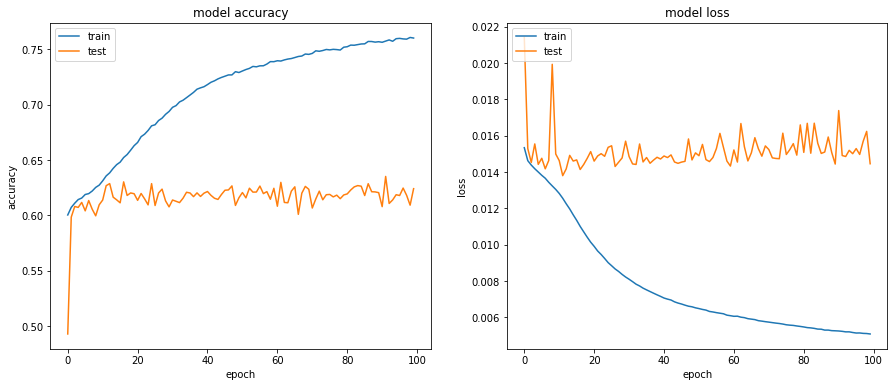

In [39]:
print(history.history.keys())
fig=plt.figure(figsize=(15, 6))
# summarize history for accuracy
fig.add_subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
fig.add_subplot(1,2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Conclusion

Notre réseau n'est guerre plus performant sur l'échatillon test seul le "surapprentissage" peux être poussé plus loin que dans l'exemple précédent mais avec un coût de calcul énorme !

## Visualisation

In [40]:
# calcul de la prédiction (long)
Y_p  = model.predict(Xnew)
Yt_p = model.predict(Xtnew)

In [41]:
# conversion de la prédiction
# enseble d'apprentissage
Imag_p=[]
for i in range(0,len(X)):
    im=np.zeros((32,32,3),np.uint8)
    im[:,:,0:1]=np.uint8(X[i]*255)
    im[:,:,1:]=np.uint8((Y_p[i][:,:,0:]+1)*128)
    image=cv2.cvtColor(im, cv2.COLOR_LAB2RGB)
    Imag_p.append(image)
# Ensemble test
Imagt_p=[]
for i in range(0,len(Xt)):
    im=np.zeros((32,32,3),np.uint8)
    im[:,:,0:1]=np.uint8(Xt[i]*255)
    im[:,:,1:]=np.uint8((Yt_p[i][:,:,0:]+1)*128)
    image=cv2.cvtColor(im, cv2.COLOR_LAB2RGB)
    Imagt_p.append(image)

## Visualisation de l'ensemble apprentissage

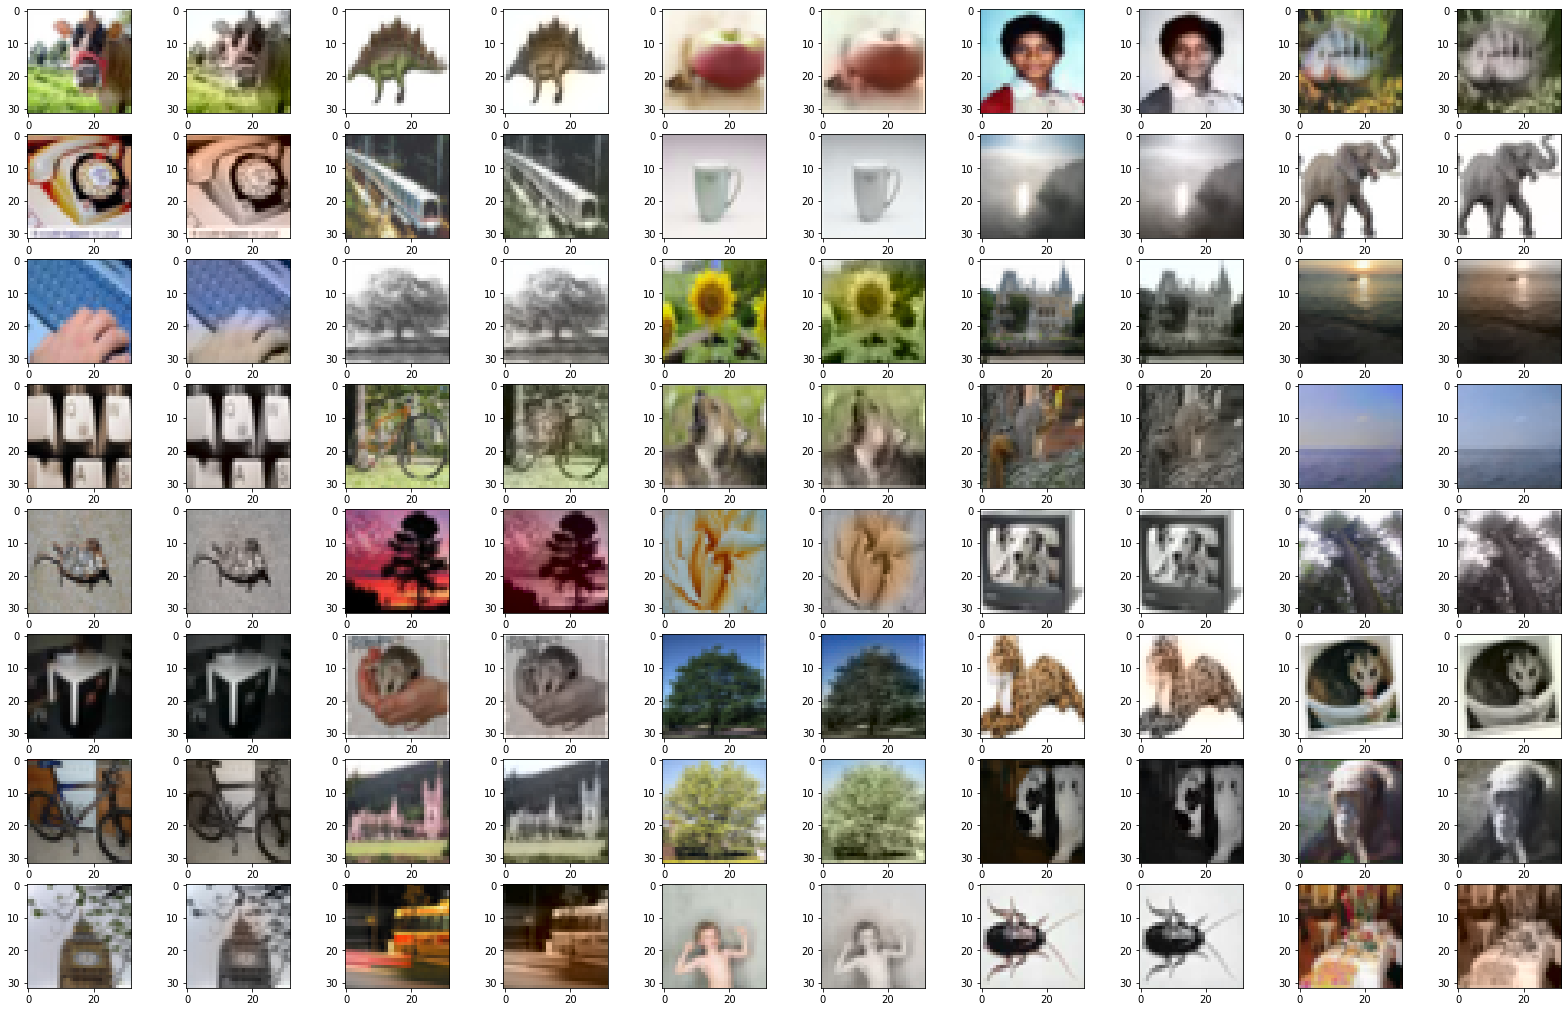

In [42]:
fig=plt.figure(figsize=(28, 18))
n=40 # multiple de 5 pour 8 lignes
start=0
for i in range(0, n):
    fig.add_subplot(8,10, 2*i+1)
    plt.imshow(x_train[i+start])
    fig.add_subplot(8,10, 2*i+2)
    plt.imshow(Imag_p[i+start])
plt.show()

## Visualisation de l'ensemble test

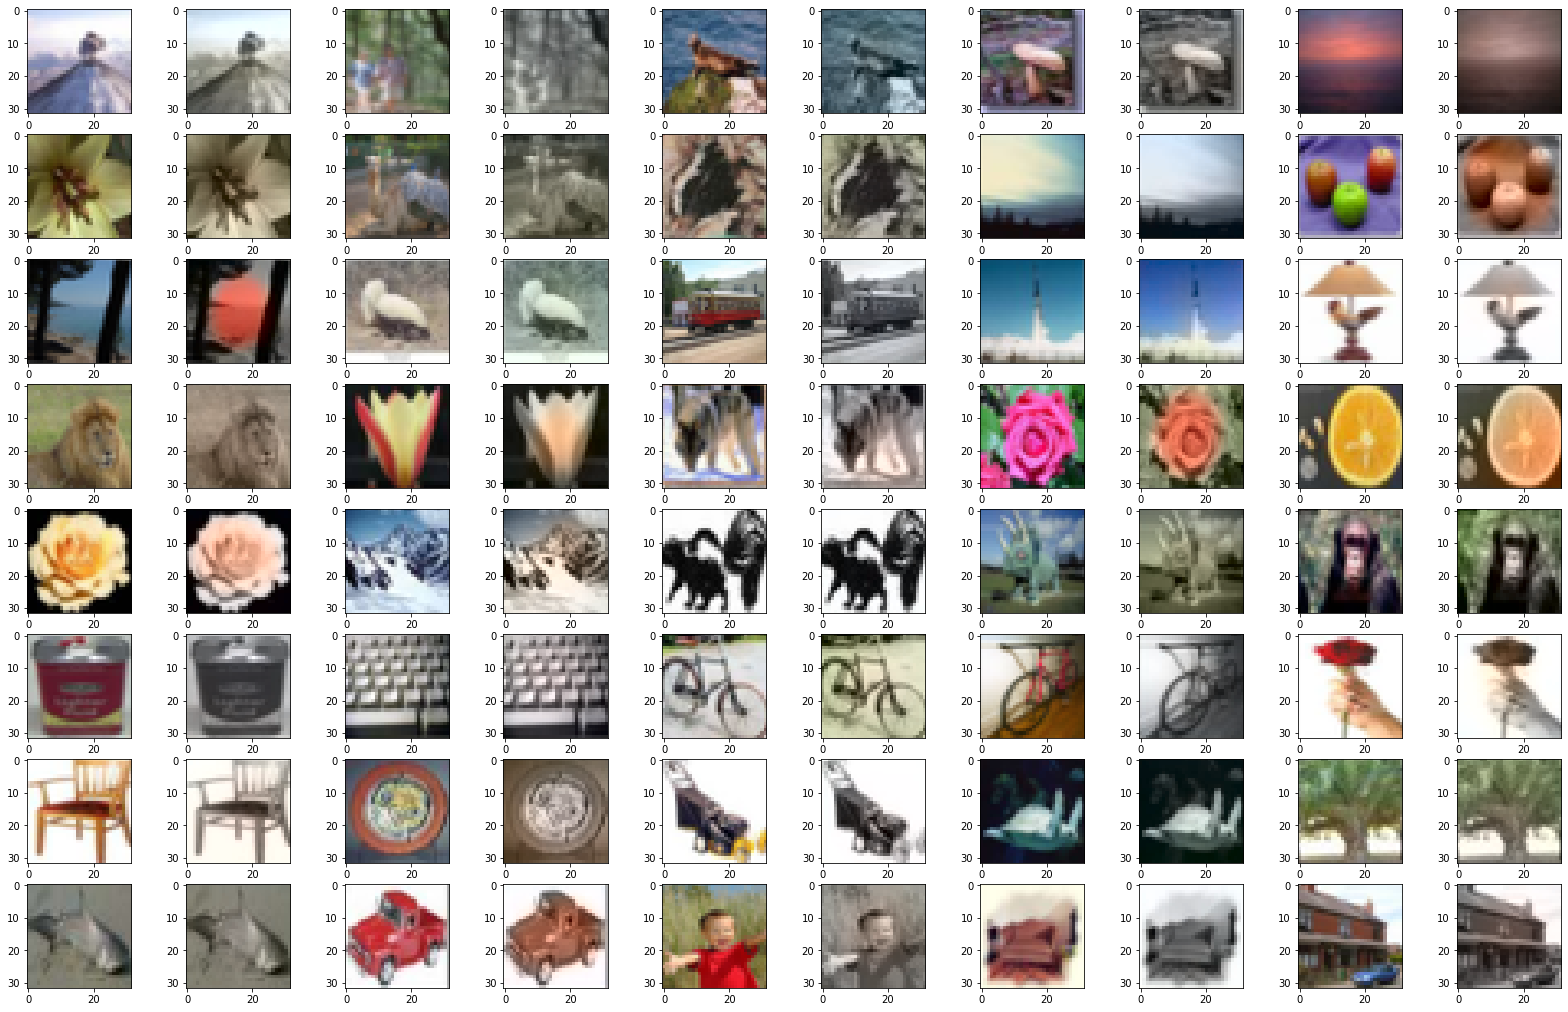

In [46]:
fig=plt.figure(figsize=(28, 18))
n=40 # multiple de 5 pour 8 lignes
start=0
for i in range(0, n):
    fig.add_subplot(8,10, 2*i+1)
    plt.imshow(x_test[i+start])
    fig.add_subplot(8,10, 2*i+2)
    plt.imshow(Imagt_p[i+start])
plt.show()

# Conclusions

Il est difficile de donner une appréciation subjective à ce dernier modèle qui me semble plus réaliste sur bon nombre de photos bien que son score soit du même ordre si l'on regarde l"accuracy".

# Au final

La mise en oeuvre d'un algorithme de colorisation est relativement simple et obtient rapidement une certaine réussite mais malgrée tout assez faible. A l'aide de moyens bien plus grands le second exemple peut donner une impression d'être meilleur mais avec un score similaire. Néanmoins la notion de score n'a aucune raison de nous donner la même hiérarchie d'appréciation du résultat. Notre apréciation va se focaliser sur des parties de verdure qui ne sont pas vertes ou un camion de pompier bien trop pâle...

Ici l'ensemble d'échantillon n'as pas été enrichi, ce qui on l'espère pourrait améliorer le score. Une autre possibilité souvent retenue pour de la colorisation automatique est de réduire la palette de couleur notemment sur les tons bleus moins perceptible par l'oeil.

La colorisation automatique reste un domaine très actif et dont on voie régulièrement le résultat dans les médias (oui je regarde la chaine histoire...)